In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.0 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.nn import CTCLoss
import torch.nn.functional as F
import torch.optim as optim
import os
from PIL import Image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
import numpy as np
import torchinfo

In [4]:
## Creating a Dataset class of loading and processing the Dataset
class TextDataset(Dataset):
    def __init__(self, image_dir, labels_file, char_set, transform=None):
        self.image_dir = image_dir
        self.labels_file = labels_file
        self.char_set = char_set
        self.transform = transform

        self.image_paths, self.labels = self._load_labels(labels_file)

        self.char_to_idx = {char: idx for idx, char in enumerate(self.char_set)}
        self.blank_token = 62

    def _load_labels(self, labels_file):
        image_paths = []
        labels = []
        with open(labels_file, 'r') as f:
            for line in f:
                _,path, label = line.strip().split(',')
                image_paths.append(os.path.join(self.image_dir, path))
                labels.append(label)
        return image_paths, labels

    def _encode_label(self, label):
        return [self.char_to_idx.get(char, self.blank_token) for char in label]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        label_encoded = self._encode_label(label)

        return image, torch.tensor(label_encoded, dtype=torch.long)

In [5]:
## The Characters the labels can have
## 26 small and 26 Capital Alphabets, 0-9 numeric charaters
our_char_set = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'


In [6]:
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((32, 100), interpolation=Image.BICUBIC),  
    transforms.ToTensor(),  
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)), 
    transforms.Normalize((0.5,), (0.5,))  
])

dataset = TextDataset(
    image_dir='/kaggle/input/text-recognition-dataset/k/dataset/images',
    labels_file='/kaggle/input/text-recognition-dataset/k/dataset/labels.csv',
    char_set=our_char_set,
    transform=transform
)


In [7]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, 0)
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)

    labels_padded = pad_sequence(labels, batch_first=True, padding_value=62)  

    return images, labels_padded, label_lengths

In [8]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

In [9]:
batch_size = 16

# our training dataset loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

val_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [10]:
def greedy_decode(output, blank_token=62):
    decoded_sequences = []
    
    for sequence in output:
        best_path = torch.argmax(sequence, dim=1).cpu().numpy()

        decoded = []
        previous = -1
        for idx in best_path:
            if idx != previous and idx != blank_token:  
                decoded.append(idx)
            previous = idx

        decoded_str = "".join([our_char_set[idx] for idx in decoded if idx in range(len(our_char_set))])
        decoded_sequences.append(decoded_str)
    
    return decoded_sequences

In [11]:
from typing import List
from Levenshtein import distance as levenshtein_distance  

def compute_edit_distance(preds: List[str], targets: List[str]) -> dict:

    total_edit_distance = 0
    total_sequences = len(preds)
    exact_matches = 0

    for pred, target in zip(preds, targets):
        edit_dist = levenshtein_distance(pred, target)
        total_edit_distance += edit_dist
        
        # Exact match
        if edit_dist == 0:
            exact_matches += 1
        
    avg_edit_distance = total_edit_distance / total_sequences
    exact_match_accuracy = exact_matches / total_sequences

    return {
        "average_edit_distance": avg_edit_distance,
        "exact_match_accuracy": exact_match_accuracy,
    }

In [12]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1

        return self.counter >= self.patience


In [13]:
def tensortochar(tensor):
    return [''.join(our_char_set[idx.item()] for idx in seq if idx.item() != 62) for seq in tensor]

In [14]:
class CRNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CRNN, self).__init__()
        
        # Block 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        # Block 2
        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        )
        
        # Block 3
        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        )
        
        # Block 4
        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))  
        )
        
        # Block 5
        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=2, stride=1, padding=0),
            nn.ReLU()
        )
        
        # LSTM layers
        self.lstm = nn.LSTM(input_size=512, hidden_size=256, num_layers=2, bidirectional=True, batch_first=True)
        
        # Fully connected layer
        self.classifier = nn.Linear(256 * 2, num_classes)  
        
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        
        x = x.squeeze(2).permute(0, 2, 1)  
        
        x, _ = self.lstm(x)  
        x = self.classifier(x)  
        
        return F.log_softmax(x, dim=2)  



input_channels = 1  
num_classes = 63  
device = "cuda" if torch.cuda.is_available() else "cpu"
mymodel = CRNN(input_channels=input_channels, num_classes=num_classes).to(device)

# Print model summary
print("Summary of the architecture (batch_size=16):")
torchinfo.summary(mymodel, input_size=(16, 1, 32, 100))

Summary of the architecture (batch_size=32):


Layer (type:depth-idx)                   Output Shape              Param #
CRNN                                     [16, 24, 63]              --
├─Sequential: 1-1                        [16, 64, 16, 50]          --
│    └─Conv2d: 2-1                       [16, 64, 32, 100]         640
│    └─ReLU: 2-2                         [16, 64, 32, 100]         --
│    └─MaxPool2d: 2-3                    [16, 64, 16, 50]          --
├─Sequential: 1-2                        [16, 128, 8, 25]          --
│    └─Conv2d: 2-4                       [16, 128, 16, 50]         73,856
│    └─ReLU: 2-5                         [16, 128, 16, 50]         --
│    └─MaxPool2d: 2-6                    [16, 128, 8, 25]          --
├─Sequential: 1-3                        [16, 256, 4, 25]          --
│    └─Conv2d: 2-7                       [16, 256, 8, 25]          295,168
│    └─ReLU: 2-8                         [16, 256, 8, 25]          --
│    └─Conv2d: 2-9                       [16, 256, 8, 25]          590,080


In [15]:
## loss function definition
blank_token = 62

loss_fun = nn.CTCLoss(blank=blank_token, reduction='mean').to(device)
## optimizer
optimizer = optim.Adadelta(mymodel.parameters(), lr=0.1)

In [16]:
epochs = 50
train_loss = []
val_loss = []
train_edit_dist = []
val_edit_dist = []
train_match_acc = []
val_match_acc = []

early_stopping = EarlyStopping()
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}\n ----")
    
    # Training Phase
    mymodel.train()
    train_loss1 = 0
    edit_dist = 0
    total_match = 0
    for batch, label, target_length in train_loader:
        batch = batch.to(device)

        label_str = tensortochar(label)

        # Forward pass
        y_batch = mymodel(batch)
        pred_str = greedy_decode(y_batch)
        input_length = torch.full(size=(batch.shape[0],), fill_value=y_batch.shape[1], dtype=torch.int32).to(device)

        dict = compute_edit_distance(pred_str, label_str)
        
        # Compute loss
        loss = loss_fun(y_batch.permute(1, 0, 2), label, input_length, target_length)
        train_loss1 += loss.item() 
        edit_dist += dict["average_edit_distance"]
        total_match += dict['exact_match_accuracy']

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss1 /= len(train_loader)
    edit_dist /= len(train_loader)
    total_match /= len(train_loader)
    train_loss.append(train_loss1)
    train_edit_dist.append(edit_dist)
    train_match_acc.append(total_match)

    # Evaluation Phase
    mymodel.eval()
    val_loss1 = 0
    edit_dist1 = 0
    total_match1 = 0
    with torch.inference_mode():
        for batch, label, target_length in val_loader:
            batch = batch.to(device)

            label_str = tensortochar(label)
            
            # Forward pass
            val_pred = mymodel(batch)
            pred_str = greedy_decode(val_pred)
            input_length = torch.full(size=(batch.shape[0],), fill_value=val_pred.shape[1], dtype=torch.int32).to(device)

            dict = compute_edit_distance(pred_str, label_str)
            
            # Compute loss
            loss = loss_fun(val_pred.permute(1, 0, 2), label, input_length, target_length)
            val_loss1 += loss.item()  
            edit_dist1 += dict["average_edit_distance"]
            total_match1 += dict['exact_match_accuracy']
            
        val_loss1 /= len(val_loader)
        edit_dist1 /= len(val_loader)
        total_match1 /= len(val_loader)
        val_loss.append(val_loss1)
        val_edit_dist.append(edit_dist1)
        val_match_acc.append(total_match1)
        print(f"Train Loss: {train_loss1} | Validation Loss: {val_loss1}")
        print(f"Average Training Edit distance: {edit_dist} | Average Validation Edit distance: {edit_dist1}")
        print(f"Average Training Match Accuracy: {total_match} | Average Validation Match Accuracy: {total_match1}")

    if early_stopping(val_loss1):
        print(f"Training halted at epoch {epoch + 1}")
        break

Epoch: 1
 ----
Train Loss: 3.8961046919226647 | Validation Loss: 3.699430580437183
Average Training Edit distance: 8.143391927083332 | Average Validation Edit distance: 7.999192708333334
Average Training Match Accuracy: 0.0 | Average Validation Match Accuracy: 0.0
Epoch: 2
 ----
Train Loss: 3.6022681832313537 | Validation Loss: 3.6090993762016295
Average Training Edit distance: 7.956673177083333 | Average Validation Edit distance: 7.844427083333334
Average Training Match Accuracy: 0.0 | Average Validation Match Accuracy: 0.0
Epoch: 3
 ----
Train Loss: 3.410174797102809 | Validation Loss: 3.3555702164769174
Average Training Edit distance: 7.772200520833333 | Average Validation Edit distance: 7.875078125
Average Training Match Accuracy: 0.0 | Average Validation Match Accuracy: 0.0
Epoch: 4
 ----
Train Loss: 3.0980682991445065 | Validation Loss: 3.0219152748584746
Average Training Edit distance: 7.554654947916667 | Average Validation Edit distance: 7.492864583333334
Average Training Match

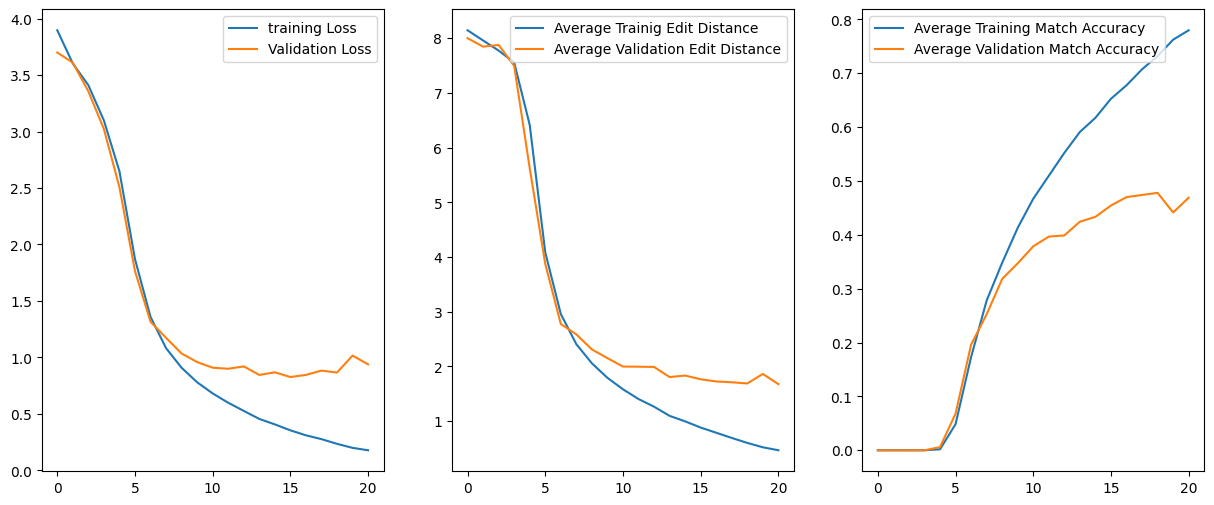

In [17]:
x=np.arange(len(train_loss))

fig, ax = plt.subplots(1,3,figsize = (15,6))
ax[0].plot(x,train_loss,label="training Loss")
ax[0].plot(x,val_loss,label="Validation Loss")
ax[0].legend()

ax[1].plot(x,train_edit_dist,label="Average Trainig Edit Distance")
ax[1].plot(x,val_edit_dist,label="Average Validation Edit Distance")
ax[1].legend()

ax[2].plot(x,train_match_acc,label="Average Training Match Accuracy")
ax[2].plot(x,val_match_acc,label="Average Validation Match Accuracy")
ax[2].legend()

plt.show()